# STEP 4: Count the number of observations in each ecosystem, during

each month of 2023

Much of the data in GBIF is **crowd-sourced**. As a result, we need not
just the number of observations in each ecosystem each month – we need
to **normalize** by some measure of **sampling effort**. After all, we
wouldn’t expect the same number of observations in the Arctic as we
would in a National Park, even if there were the same number of Veeries.
In this case, we’re normalizing using the average number of observations
for each ecosystem and each month. This should help control for the
number of active observers in each location and time of year.

### Set up your analysis

First things first – let’s load your stored variables.

In [12]:
%store -r

### Identify the ecoregion for each observation

You can combine the ecoregions and the observations **spatially** using
a method called `.sjoin()`, which stands for spatial join.

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-read"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Read More</div></div><div class="callout-body-container callout-body"><p>Check out the <a
href="https://geopandas.org/en/stable/docs/user_guide/mergingdata.html#spatial-joins"><code>geopandas</code>
documentation on spatial joins</a> to help you figure this one out. You
can also ask your favorite LLM (Large-Language Model, like ChatGPT)</p></div></div>

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It: Perform a spatial join</div></div><div class="callout-body-container callout-body"><ol type="1">
<li>Identify the correct values for the <code>how=</code> and
<code>predicate=</code> parameters of the spatial join.</li>
<li>Select only the columns you will need for your plot.</li>
<li>Run the code.</li>
</ol></div></div>

In [13]:
gbif_gdf

,month,geometry
gbifID,,
4704199879,2,POINT (-81.68694 26.64967)
4826111054,5,POINT (-80.79118 41.43764)
4668276308,5,POINT (-95.98026 46.99181)
4670343687,6,POINT (-77.27846 43.90822)
4716598123,4,POINT (-88.95966 43.12798)
...,...,...
4678731776,3,POINT (-85.15653 42.24512)
4816316846,12,POINT (-85.00603 35.40836)
4685501560,1,POINT (-123.5424 46.97668)


In [14]:
gdf_ecoregions

,OBJECTID,ECO_NAME,BIOME_NUM,BIOME_NAME,REALM,ECO_BIOME_,NNH,ECO_ID,SHAPE_LENG,SHAPE_AREA,NNH_NAME,COLOR,COLOR_BIO,COLOR_NNH,LICENSE,geometry
ecoregion,,,,,,,,,,,,,,,,
0,1.0,Adelie Land tundra,11.0,Tundra,Antarctica,AN11,1,117,9.749780,0.038948,Half Protected,#63CFAB,#9ED7C2,#257339,CC-BY 4.0,"MULTIPOLYGON (((158.7141 -69.60657, 158.71264 ..."
1,2.0,Admiralty Islands lowland rain forests,1.0,Tropical & Subtropical Moist Broadleaf Forests,Australasia,AU01,2,135,4.800349,0.170599,Nature Could Reach Half Protected,#70A800,#38A700,#7BC141,CC-BY 4.0,"MULTIPOLYGON (((147.28819 -2.57589, 147.2715 -..."
2,3.0,Aegean and Western Turkey sclerophyllous and m...,12.0,"Mediterranean Forests, Woodlands & Scrub",Palearctic,PA12,4,785,162.523044,13.844952,Nature Imperiled,#FF7F7C,#FE0000,#EE1E23,CC-BY 4.0,"MULTIPOLYGON (((26.88659 35.32161, 26.88297 35..."
3,4.0,Afghan Mountains semi-desert,13.0,Deserts & Xeric Shrublands,Palearctic,PA13,4,807,15.084037,1.355536,Nature Imperiled,#FA774D,#CC6767,#EE1E23,CC-BY 4.0,"MULTIPOLYGON (((65.48655 34.71401, 65.52872 34..."
4,5.0,Ahklun and Kilbuck Upland Tundra,11.0,Tundra,Nearctic,NE11,1,404,22.590087,8.196573,Half Protected,#4C82B6,#9ED7C2,#257339,CC-BY 4.0,"MULTIPOLYGON (((-160.26404 58.64097, -160.2673..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
842,848.0,Sulawesi lowland rain forests,1.0,Tropical & Subtropical Moist Broadleaf Forests,Australasia,AU01,2,156,150.744361,9.422097,Nature Could Reach Half Protected,#70A800,#38A700,#7BC141,CC-BY 4.0,"MULTIPOLYGON (((117.33111 -7.53306, 117.30525 ..."
843,212.0,East African montane forests,1.0,Tropical & Subtropical Moist Broadleaf Forests,Afrotropic,AF01,3,8,157.848926,5.010930,Nature Could Recover,#13ED00,#38A700,#F9A91B,CC-BY 4.0,"MULTIPOLYGON (((36.7375 -3.13, 36.7375 -3.1316..."
844,224.0,Eastern Arc forests,1.0,Tropical & Subtropical Moist Broadleaf Forests,Afrotropic,AF01,3,9,34.153333,0.890325,Nature Could Recover,#267400,#38A700,#F9A91B,CC-BY 4.0,"MULTIPOLYGON (((36.38 -8.96583, 36.38 -8.96667..."


In [15]:
gbif_ecoregion_gdf = (
    gdf_ecoregions
    # Match the CRS of the GBIF data and the ecoregions
    .to_crs(gbif_gdf.crs)
    # Find ecoregion for each observation
    .sjoin(
        gbif_gdf,
        how='inner', 
        predicate='contains')
    # Select the required columns
    [['month', 'gbifID', 'SHAPE_AREA']]
     .reset_index()
     .rename(columns={
         'index':'ecoregion',
         'gbifID' : 'observation_id' #needed to reset index to get unquie IDs for every row 
     })
)
gbif_ecoregion_gdf

,ecoregion,month,observation_id,SHAPE_AREA
0,4,7,4792706312,8.196573
1,4,7,4795806198,8.196573
2,4,7,4620196883,8.196573
3,4,7,4700107974,8.196573
4,4,7,4660852026,8.196573
...,...,...,...,...
304703,833,6,4729374620,35.905513
304704,833,5,4644361401,35.905513
304705,833,5,4763013510,35.905513
304706,833,5,4843448578,35.905513


### Count the observations in each ecoregion each month

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It: Group observations by ecoregion</div></div><div class="callout-body-container callout-body"><ol type="1">
<li>Replace <code>columns_to_group_by</code> with a list of columns.
Keep in mind that you will end up with one row for each group – you want
to count the observations in each ecoregion by month.</li>
<li>Select only month/ecosystem combinations that have more than one
occurrence recorded, since a single occurrence could be an error.</li>
<li>Use the <code>.groupby()</code> and <code>.mean()</code> methods to
compute the mean occurrences by ecoregion and by month.</li>
<li>Run the code – it will normalize the number of occurrences by month
and ecoretion.</li>
</ol></div></div>

In [16]:
occurrence_df = (
    gbif_ecoregion_gdf
    #reset indes
    .reset_index()
    # For each ecoregion, for each month...
    .groupby(['ecoregion', 'month'])
    # ...count the number of occurrences
    #.agg counts all of GBIF Ids in the group 
    .agg(
        occurrences=('observation_id', 'count'),
        area=('SHAPE_AREA', 'first'))  
)
#normalize by area 
occurrence_df['density'] = (
    occurrence_df.occurrences 
    / occurrence_df.area
)

# Get rid of rare observations (possible misidentification?)
occurrence_df = occurrence_df[occurrence_df.occurrences>1]

# Take the mean by ecoregion
mean_occurrences_by_ecoregion = (
    occurrence_df
    .groupby(['ecoregion'])
    .mean()
)
# Take the mean by month
mean_occurrences_by_month = (
    occurrence_df
    .groupby(['month'])
    .mean()
)

In [17]:
occurrence_df


occurrences       area   density
ecoregion month                                  
4         7                5   8.196573  0.610011
9         5                3  28.388010  0.105678
          6                2  28.388010  0.070452
          8                8  28.388010  0.281809
          9               13  28.388010  0.457940
...                      ...        ...       ...
833       7              167  35.905513  4.651096
          8              173  35.905513  4.818202
          9              128  35.905513  3.564912
          10              94  35.905513  2.617982
          11              25  35.905513  0.696272

[780 rows x 3 columns]

In [18]:
mean_occurrences_by_month


,occurrences,area,density
month,,,
1,411.641509,12.787615,50.791284
2,404.153846,14.793152,30.434700
3,502.564516,16.346530,31.429515
4,628.661972,23.445993,35.427309
5,628.901235,24.015157,33.831444
6,293.722222,32.080428,16.574085
7,220.100000,32.523085,11.757105
8,257.514286,33.824738,13.596181
9,283.295775,28.195064,17.823235


In [19]:
mean_occurrences_by_ecoregion

,occurrences,area,density
ecoregion,,,
4,5.000000,8.196573,0.610011
9,6.500000,28.388010,0.228970
10,2.000000,7.247315,0.275964
12,27.166667,17.133639,1.585575
15,18.500000,1.639273,11.285492
...,...,...,...
820,8.166667,1.382287,5.908084
821,79.900000,9.664680,8.267216
822,5.000000,64.674744,0.077310


### Normalize the observations

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It: Normalize</div></div><div class="callout-body-container callout-body"><ol type="1">
<li>Divide occurrences by the mean occurrences by month AND the mean
occurrences by ecoregion</li>
</ol></div></div>

In [20]:
# Normalize by space and time for sampling effort
occurrence_df['norm_occurrences'] = (
    occurrence_df['density']
    /mean_occurrences_by_ecoregion['density']
    /mean_occurrences_by_month['density']
)
occurrence_df

occurrences       area   density  norm_occurrences
ecoregion month                                                    
4         7                5   8.196573  0.610011          0.085055
9         5                3  28.388010  0.105678          0.013642
          6                2  28.388010  0.070452          0.018565
          8                8  28.388010  0.281809          0.090523
          9               13  28.388010  0.457940          0.112213
...                      ...        ...       ...               ...
833       7              167  35.905513  4.651096          0.087380
          8              173  35.905513  4.818202          0.078276
          9              128  35.905513  3.564912          0.044180
          10              94  35.905513  2.617982          0.029165
          11              25  35.905513  0.696272          0.005931

[780 rows x 4 columns]

<Axes: xlabel='month', ylabel='norm_occurrences'>

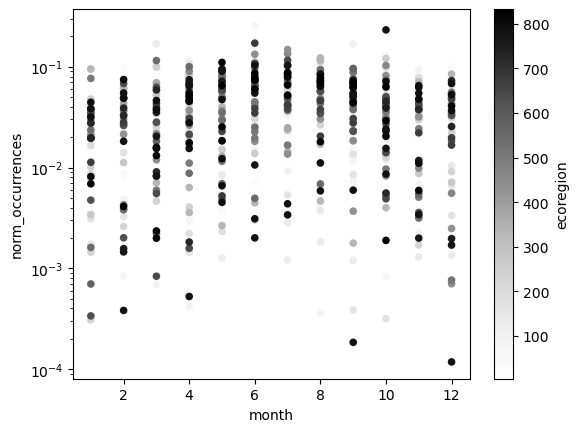

In [21]:
occurrence_df.reset_index().plot.scatter(
    x='month', y='norm_occurrences', c='ecoregion',
    logy=True
)

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It</div></div><div class="callout-body-container callout-body"><p>Make sure to store the new version of your <code>DataFrame</code> for
other notebooks!</p>
<div id="2e01613b" class="cell" data-execution_count="9">
<div class="sourceCode" id="cb1"><pre
class="sourceCode python cell-code"><code class="sourceCode python"><span id="cb1-1"><a href="#cb1-1" aria-hidden="true" tabindex="-1"></a><span class="op">%</span>store occurrence_df</span></code></pre></div>
</div></div></div>

In [22]:
%store occurrence_df

Stored 'occurrence_df' (DataFrame)
